### Trying to cluster

In [1]:
import functions

import os
import scipy.io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [2]:
rsfMRI_info = pd.read_excel("TiMeS_rsfMRI_info.xlsx", engine="openpyxl")  
regression_info = pd.read_excel("TiMeS_regression_info_processed.xlsx", engine="openpyxl")
rsfMRI_full_info = pd.read_excel("TiMeS_rsfMRI_full_info.xlsx", engine="openpyxl")
print(regression_info.columns)
regression_info=regression_info[['Stroke_location', 'Lesion_side', 'lesion_volume_mm3']]

Index(['subject_id', 'TimePoint', 'Behavioral_assessment', 'MRI', 'Gender',
       'Age', 'Education_level', 'Lesion_side_old', 'Lesion_side', 'Combined',
       'Bilateral', 'Comments', 'Stroke_location', 'lesion_volume_mm3',
       'NIHSS', 'FAB_abstraction', 'FAB_flexibility', 'FAB_programmation',
       'FAB_sensitivity_to_interference', 'FAB_inhibitory_control',
       'FAB_environmental_autonomy', 'FAB_TOT', 'Stroop_color_time',
       'Stroop_color_error', 'Stroop_words_time', 'Stroop_words_error',
       'Stroop_interference_time', 'Stroop_interference_error',
       'Stroop_index_WC', 'Stroop_index_InC', 'Digit_forward_SPAN',
       'Digit_forward_TOTAL', 'Digit_backward_SPAN', 'Digit_backward_TOTAL',
       'Digit_sequencing_SPAN', 'Digit_sequencing_TOTAL', 'Digit_TOTAL',
       'Fugl_Meyer_right_UPPER_EXTREMITY', 'Fugl_Meyer_right_WRIST',
       'Fugl_Meyer_right_HAND', 'Fugl_Meyer_right_COORDINATION_SPEED',
       'Fugl_Meyer_right_TOTAL', 'Fugl_Meyer_left_UPPER_EXTREMITY',

In [ ]:
# Folder containing the data
folder_path = "FC_matrices_times_wp11/"

# keep only ROIS
rois = [363, 364, 365, 368, 372, 373, 374, 377, 379, 361, 370, 362, 371, 10, 11, 12, 54, 56, 78, 96, 190, 191, 192, 234, 236, 258, 276, 8, 9, 51, 52, 53, 188, 189, 231, 232, 233]
rois = [roi - 1 for roi in rois]

t1_matrices, rsfMRI_full_info, rsfMRI_info, t1_subjects = functions.load_data_T1_only(folder_path, rois)
all_matrices, rsfMRI_full_info, rsfMRI_info, all_subjects = functions.load_data(folder_path, rois)
t1_t3_matrices, rsfMRI_full_info, rsfMRI_info, t1_t3_subjects = functions.load_data_2(folder_path, rois)
t1_t4_matrices, rsfMRI_full_info, rsfMRI_info, t1_t4_subjects = functions.load_data_3(folder_path, rois)
#matrices = functions.matrices_to_wide_df(matrices)

In [15]:
print("number of subjects with all matrices: ", len(all_subjects))
print("number of subjects with T1 and T3 matrices: ", len(t1_t3_subjects))
print("number of subjects with T1 and T4 matrices: ", len(t1_t4_subjects))

number of subjects with all matrices:  22
number of subjects with T1 and T3 matrices:  39
number of subjects with T1 and T4 matrices:  36


Better to keep T1 and T3 as more subjects have these two !
From now on I'll work with matrices

In [16]:
print("matrices column names: ", t1_t3_matrices.columns)

matrices column names:  Index(['subject_id', 'T1_matrix', 'T3_matrix', 'Lesion_side',
       'Stroke_location', 'lesion_volume_mm3'],
      dtype='object')


##### Cluster for all matrices

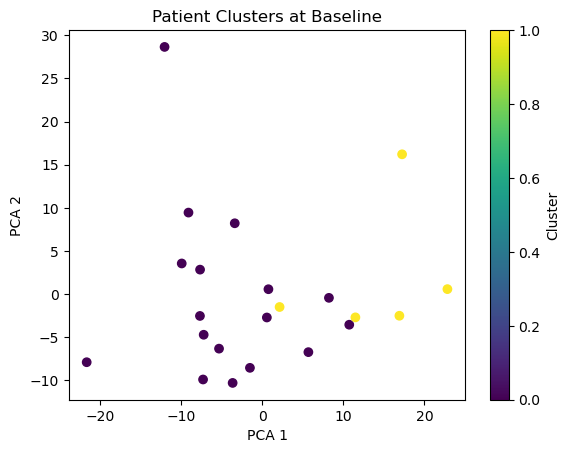

In [21]:
categorical_cols = ['Lesion_side', 'Stroke_location']
numerical_cols = ['lesion_volume_mm3']

functions.cluster_and_plot(all_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols)

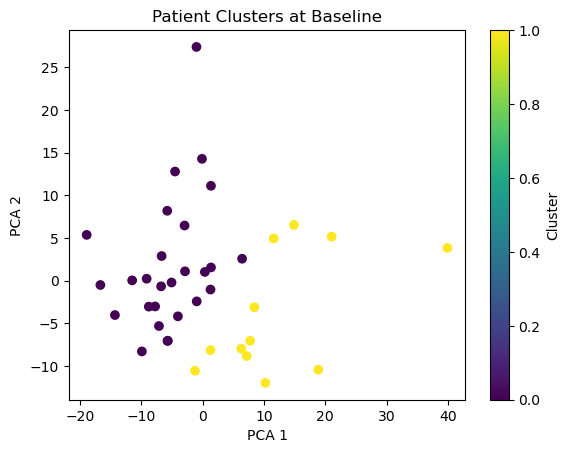

In [22]:
functions.cluster_and_plot(t1_t3_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols)

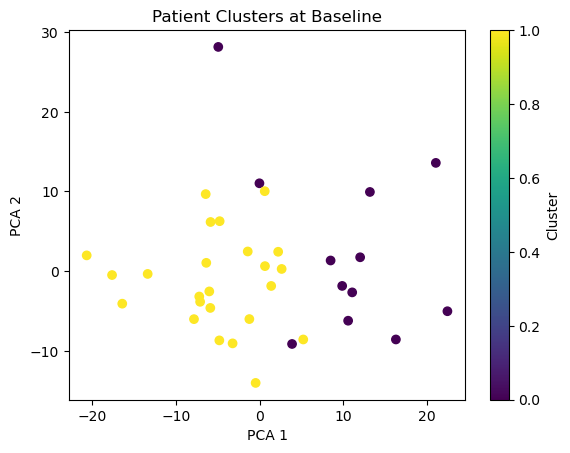

In [23]:
functions.cluster_and_plot(t1_t4_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols)

In [ ]:
# Create a DataFrame mapping subject IDs to their cluster labels
subject_cluster_df = pd.DataFrame({'subject_id': subject_ids, 'cluster': labels})

# Merge the cluster DataFrame with the original DataFrame (matrices)
matrices_with_clusters = matrices.merge(subject_cluster_df, on='subject_id', how='left')
matrices_with_clusters

  subject_id                                          T1_matrix  \
0       s036            362       363       364       367  3...   
1       s008            362       363       364       367   ...   
2       s039            362       363       364       367   ...   
3       s006            362       363       364       367   ...   
4       s001            362       363       364       367   ...   

                                           T2_matrix  \
0            362       363       364       367   ...   
1            362       363       364       367   ...   
2            362       363       364       367   ...   
3            362       363       364       367   ...   
4            362       363       364       367   ...   

                                           T3_matrix  \
0            362       363       364       367   ...   
1            362       363       364       367   ...   
2            362       363       364       367   ...   
3            362       363       364

KeyboardInterrupt: 

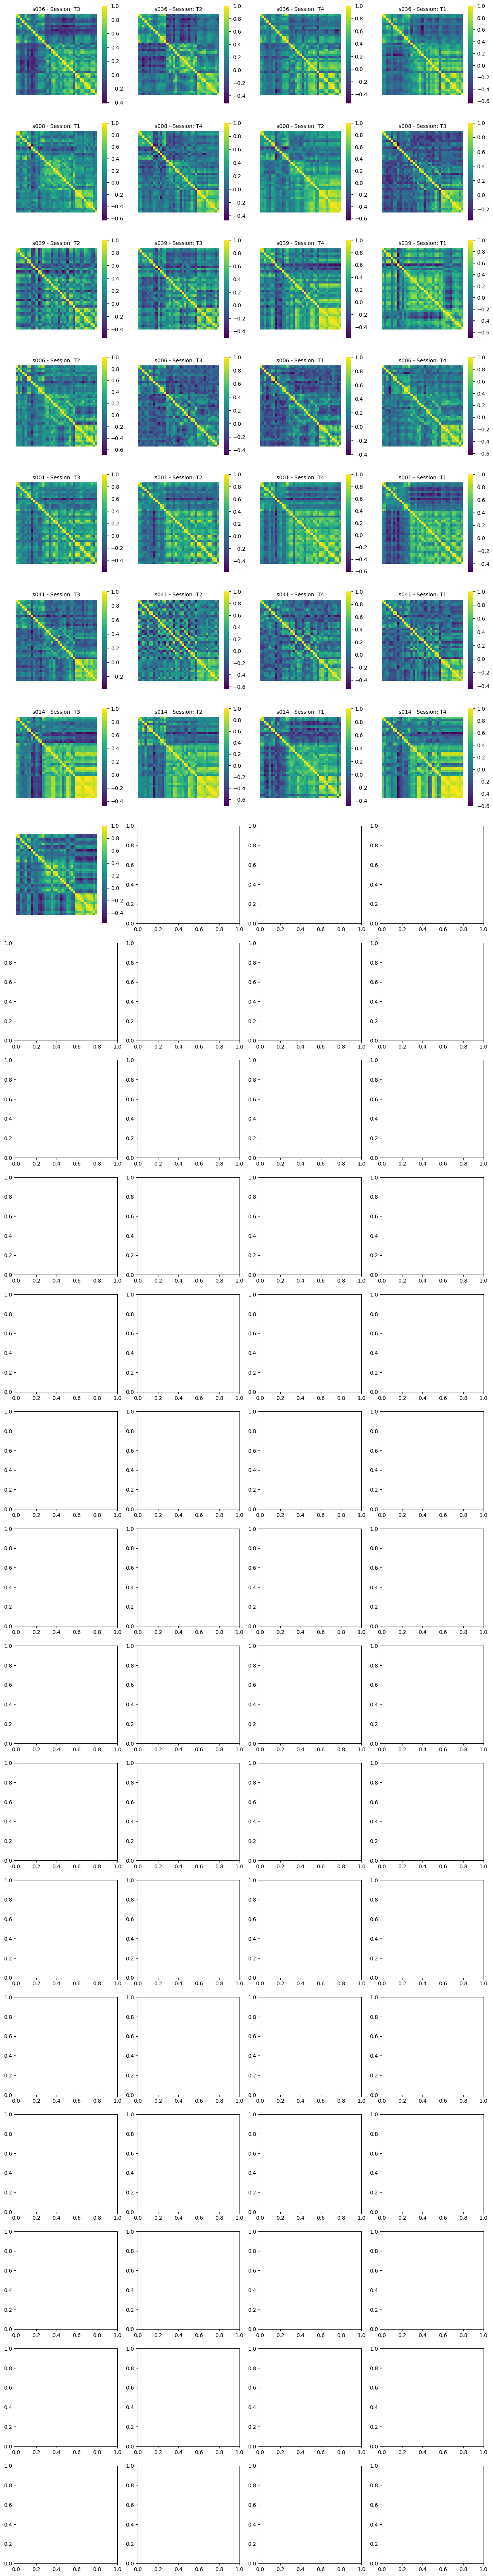

In [22]:
functions.plot_all_subject_matrices(folder_path, rois)

### Beginning of statistical testing

X_T1 shape:  (22, 666)
X_T4 shape:  (22, 666)


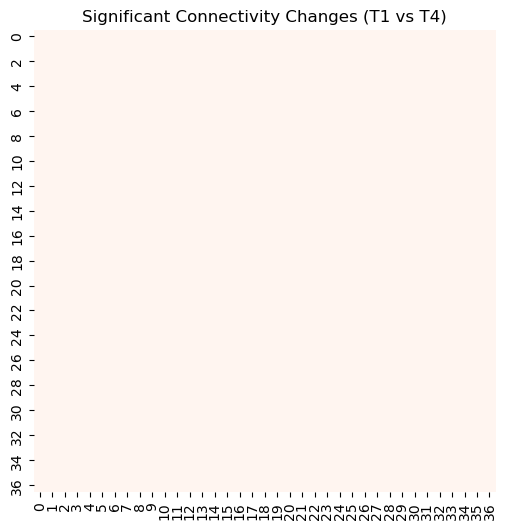

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [27]:
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests
import numpy as np

def compare_T1_T4(df, rois, alpha=0.05):
    T1_matrices = df['T1_matrix'].dropna()
    T4_matrices = df['T4_matrix'].dropna()

    # Ensure matching subjects
    common_subjects = set(T1_matrices.index) & set(T4_matrices.index)
    T1 = [flatten_upper(df.loc[s, 'T1_matrix']) for s in common_subjects]
    T4 = [flatten_upper(df.loc[s, 'T4_matrix']) for s in common_subjects]

    X_T1 = np.array(T1)
    print("X_T1 shape: ", np.shape(X_T1))
    X_T4 = np.array(T4)
    print("X_T4 shape: ", np.shape(X_T4))

    # Paired t-test
    t_stats, p_vals = ttest_rel(X_T1, X_T4, axis=0)

    # Multiple comparisons correction (FDR)
    reject, p_vals_corrected, _, _ = multipletests(p_vals, alpha=alpha, method='fdr_bh')

    # Create a matrix to visualize
    n_edges = X_T1.shape[1]
    n_rois = len(rois)
    signif_matrix = np.zeros((n_rois, n_rois))

    # Fill upper triangle
    triu_idx = np.triu_indices(n_rois, k=1)
    signif_matrix[triu_idx] = reject.astype(int)
    signif_matrix += signif_matrix.T  # Make symmetric

    return signif_matrix, p_vals_corrected.reshape(-1), reject.reshape(-1)

# Visualize
signif_matrix, p_corrected, reject = compare_T1_T4(matrices, rois)

plt.figure(figsize=(8, 6))
sns.heatmap(signif_matrix, cmap='Reds', square=True, cbar=False)
plt.title('Significant Connectivity Changes (T1 vs T4)')
plt.show()
print(signif_matrix)


In [25]:
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compare_T1_T4_by_cluster(df, rois, alpha=0.05):
    n_rois = len(rois)
    results = {}

    for cluster in sorted(df['cluster'].unique()):
        print(f"\nAnalyzing Cluster {cluster}...")

        # Subset to current cluster
        cluster_df = df[df['cluster'] == cluster]

        # Ensure subjects have both T1 and T4
        cluster_df = cluster_df.dropna(subset=['T1_matrix', 'T4_matrix'])

        if cluster_df.empty:
            print(f" - No data for Cluster {cluster}")
            continue

        # Flatten matrices
        X_T1 = np.array([flatten_upper(m) for m in cluster_df['T1_matrix']])
        X_T4 = np.array([flatten_upper(m) for m in cluster_df['T4_matrix']])

        # Paired t-test
        t_stats, p_vals = ttest_rel(X_T1, X_T4, axis=0)

        # FDR correction
        reject, p_vals_corrected, _, _ = multipletests(p_vals, alpha=alpha, method='fdr_bh')

        # Create symmetric significance matrix
        signif_matrix = np.zeros((n_rois, n_rois))
        triu_idx = np.triu_indices(n_rois, k=1)
        signif_matrix[triu_idx] = reject.astype(int)
        signif_matrix += signif_matrix.T

        # Store results
        results[cluster] = {
            'signif_matrix': signif_matrix,
            'p_corrected': p_vals_corrected,
            'rejected': reject,
        }

        # Plot
        plt.figure(figsize=(7, 6))
        sns.heatmap(signif_matrix, cmap='Reds', square=True, cbar=False)
        plt.title(f'Significant Changes (T1 vs T4) - Cluster {cluster}')
        plt.tight_layout()
        plt.show()

    return results



Analyzing Cluster 0...


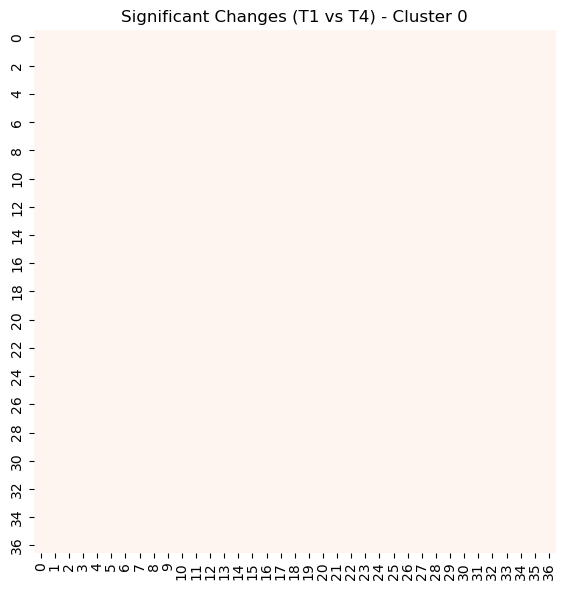


Analyzing Cluster 1...


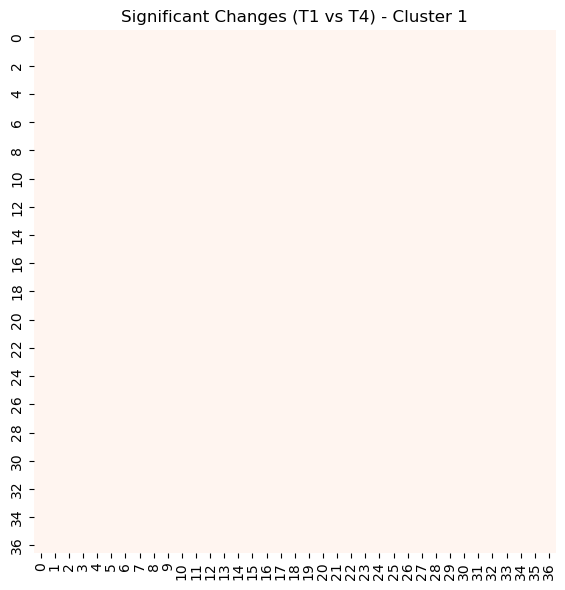

{0: {'signif_matrix': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'p_corrected': array([0.97722553, 0.89403077, 0.95225535, 0.8757599 , 0.47900341,
         0.89766851, 0.95225535, 0.77752457, 0.68935826, 0.50750301,
         0.57556295, 0.8757599 , 0.93141018, 0.87834802, 0.74399494,
         0.62819977, 0.68274441, 0.47900341, 0.94429401, 0.88955566,
         0.8026915 , 0.91477946, 0.91590953, 0.69681328, 0.91885676,
         0.78788316, 0.50750301, 0.38412906, 0.27861906, 0.38329947,
         0.50750301, 0.42969723, 0.37218789, 0.76918097, 0.62379191,
         0.34337617, 0.8757599 , 0.87834802, 0.82822571, 0.65265461,
         0.79246708, 0.98908196, 0.77752457, 0.73188149, 0.57439885,
         0.5620883 , 0.93352667, 0.9148632 , 0.80718506, 0.83967057,
         0.8888133 

In [26]:
compare_T1_T4_by_cluster(matrices_with_clusters, rois)